<a href="https://colab.research.google.com/github/LC1332/Speaker-Grouping/blob/main/notebook/%E7%BD%AE%E4%BF%A1%E5%BA%A6%E6%A8%A1%E5%9E%8B%E8%AE%AD%E7%BB%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - [ ] 读取parquet文件
 - [ ] 标注置信度
 - [ ] 训练标注度回归，看一看散点图

# 读取parquet

In [15]:
import pandas as pd

# 读取 Parquet 文件到 pandas DataFrame
data = pd.read_parquet("/content/liangjian_10_feature.parquet")
# data = pd.read_parquet("/content/haruhi_03_feature.parquet")

# 打印所有列名
print("所有列名：")
for col in data.columns:
    print(col)


所有列名：
人物
人物台词
开始时间
结束时间
audio_file
screeshot_file
visual_feature
audio_feature


# 计算audio_feature_matrix的训练函数

In [16]:
import numpy as np
import pandas as pd

# 假设 data 是已经加载的 DataFrame
# 将 audio_feature 列中的每个 list of float 转换为一个 NumPy 矩阵
audio_features_matrix = np.stack(data['audio_feature'].values)
speaker_labels = data['人物'].tolist()

In [17]:
#@title 定义calculate_confidences(audio_features_matrix, speaker_labels)

import numpy as np
from sklearn.neighbors import NearestNeighbors

def calculate_confidences(audio_features_matrix, speaker_labels, sample_prob=0.1, sample_size=2, n_neighbors=25):
    # 计算 L2 范数
    norms = np.linalg.norm(audio_features_matrix, axis=1, keepdims=True)
    # 归一化特征矩阵
    normalized_audio_features_matrix = audio_features_matrix / norms
    # 创建并拟合模型
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(normalized_audio_features_matrix)
    # 获取近邻
    distances, indices = knn.kneighbors(normalized_audio_features_matrix)

    def compute_false_prob(is_correct):
        n = len(is_correct)
        p = [[0.0 for _ in range(sample_size + 1)] for _ in range(n + 1)]
        exit_prob = [0.0 for _ in range(n+1)]

        p[0][0] = 1.0
        for i in range(1, n + 1):
            exit_prob[i] = exit_prob[i - 1]
            p[i][sample_size] = p[i - 1][sample_size]

            for l in range(0, sample_size):
                if is_correct[i - 1]:
                    p[i][l] = p[i - 1][l] * (1 - sample_prob)
                    exit_prob[i] += p[i - 1][l] * sample_prob
                else:
                    p[i][l] = p[i - 1][l] * (1 - sample_prob)
                    if l > 0:
                        p[i][l] += p[i - 1][l - 1] * sample_prob

            if not is_correct[i - 1]:
                p[i][sample_size] += p[i - 1][sample_size - 1] * sample_prob

        return p[n][sample_size]

    confidences = []
    n = len(indices)
    for i in range(n):
        speaker_i = speaker_labels[i]
        indice = indices[i][1:]  # 排除自身
        speakers = [speaker_labels[j] for j in indice]
        is_correct = [speaker_i == speaker for speaker in speakers]
        confidence = 1 - compute_false_prob(is_correct)
        confidences.append(confidence)

    return confidences



In [18]:
confidences = calculate_confidences(audio_features_matrix, speaker_labels)
print(confidences[:10])

[0.5747951438536869, 0.6800265259698838, 0.903107956390941, 0.7895320663884968, 0.8553822847204733, 0.8650047454646987, 0.7741548181934974, 0.8384007862674976, 0.88630083434934, 0.6954435816920101]


# 回归confidences的初步尝试

data是一个表格

其中 audio_feature 是 一个list of float形式的特征

"人物" 代表speaker的标签

同时我还得到了一个list of float 的变量confidences

我希望建立audio_feature到 confidence的回归

同时，忽略掉人物为none的数据

从数据中取出1/10作为测试数据，绘制测试数据的ground truth vs. response的散点图

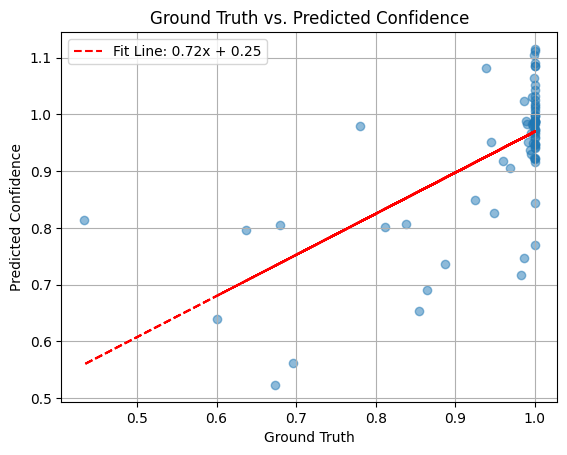

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# 创建一个临时 DataFrame 来合并人物标签和置信度，以便同步处理
temp_data = data.copy()
temp_data['confidences'] = confidences

# 忽略人物为 None 的数据
data_with_label = temp_data[temp_data['人物'].notna()]

# 从筛选后的 DataFrame 中提取特征和置信度
features = np.array(data_with_label['audio_feature'].tolist())
confidences_filtered = data_with_label['confidences'].tolist()

# 拆分数据集，取 1/10 作为测试集
X_train, X_test, y_train, y_test = train_test_split(features, confidences_filtered, test_size=0.1)

# 建立神经网络回归模型
# 示例中设置了两个隐层，每个层100个节点
model = MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', max_iter=500)

# 训练模型
model.fit(X_train, y_train)

# 使用模型进行预测
predictions = model.predict(X_test)



# 绘制散点图比较真实值和预测值
plt.scatter(y_test, predictions, alpha=0.5)

# 计算拟合线
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)


# 绘制拟合线
plt.plot(y_test, p(y_test), "r--", label=f'Fit Line: {p[1]:.2f}x + {p[0]:.2f}')

# 添加图例和图表信息
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Confidence')
plt.title('Ground Truth vs. Predicted Confidence')
plt.legend()
plt.grid(True)
plt.show()


# 试一下visual feature

In [24]:
import numpy as np
import pandas as pd

visual_features_matrix = np.stack(data['visual_feature'].values)
speaker_labels = data['人物'].tolist()

In [25]:
visual_confidences = calculate_confidences(visual_features_matrix, speaker_labels)
print(visual_confidences[:10])

[0.7821110794401092, 0.7435936269479249, 0.687722753196506, 0.6349282780983585, 0.6665172119155072, 0.7199626387480016, 0.8351772082861543, 0.7966518804067234, 0.8307757268514057, 0.567240441549122]


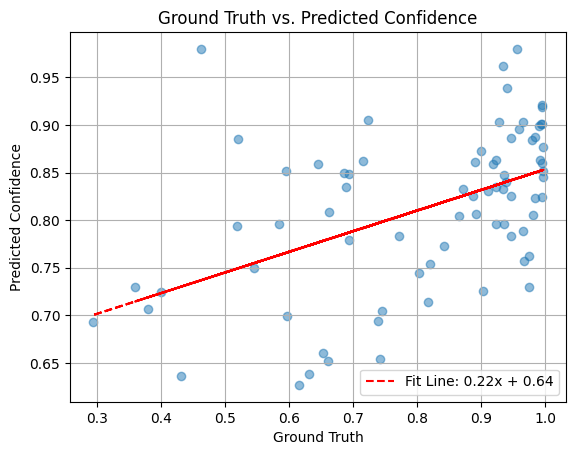

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# 创建一个临时 DataFrame 来合并人物标签和置信度，以便同步处理
temp_data = data.copy()
temp_data['confidences'] = visual_confidences

# 忽略人物为 None 的数据
data_with_label = temp_data[temp_data['人物'].notna()]

# 从筛选后的 DataFrame 中提取特征和置信度
features = np.array(data_with_label['visual_feature'].tolist())
confidences_filtered = data_with_label['confidences'].tolist()

# 拆分数据集，取 1/10 作为测试集
X_train, X_test, y_train, y_test = train_test_split(features, confidences_filtered, test_size=0.1)

# 建立神经网络回归模型
# 示例中设置了两个隐层，每个层100个节点
model = MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', max_iter=500)

# 训练模型
model.fit(X_train, y_train)

# 使用模型进行预测
predictions = model.predict(X_test)

# 绘制散点图比较真实值和预测值
plt.scatter(y_test, predictions, alpha=0.5)

# 计算拟合线
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)

# 绘制拟合线
plt.plot(y_test, p(y_test), "r--", label=f'Fit Line: {p[1]:.2f}x + {p[0]:.2f}')

# 添加图例和图表信息
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Confidence')
plt.title('Ground Truth vs. Predicted Confidence')
plt.legend()
plt.grid(True)
plt.show()
